In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('EAE_Data.csv', parse_dates=['timestamp'], index_col='timestamp')

# Handle missing values
data.fillna(method='ffill', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Convert to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

C:\Users\sesa572601\AppData\Local\Temp\ipykernel_37508\3831051317.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [3]:
scaled_df.head(5)

,cpu,memory,cpu-energy,memory-energy,sci-e
timestamp,,,,,
2024-07-30 14:06:54,0.079366,0.089476,0.079367,0.089476,0.086606
2024-07-30 14:06:55,0.079907,0.089476,0.079908,0.089476,0.086616
2024-07-30 14:06:55,0.079348,0.089476,0.079349,0.089476,0.086605
2024-07-30 14:06:55,0.078939,0.089476,0.078940,0.089476,0.086598
2024-07-30 14:06:55,0.050022,0.089476,0.050022,0.089476,0.086053


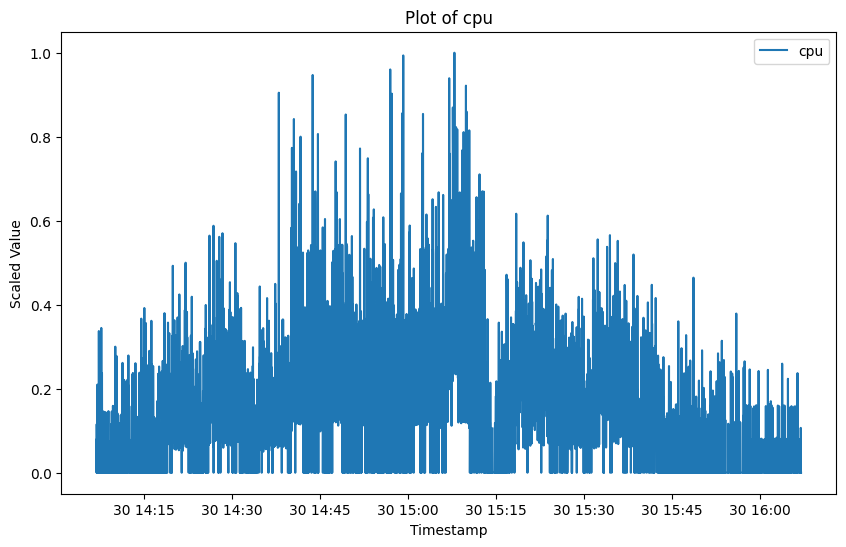

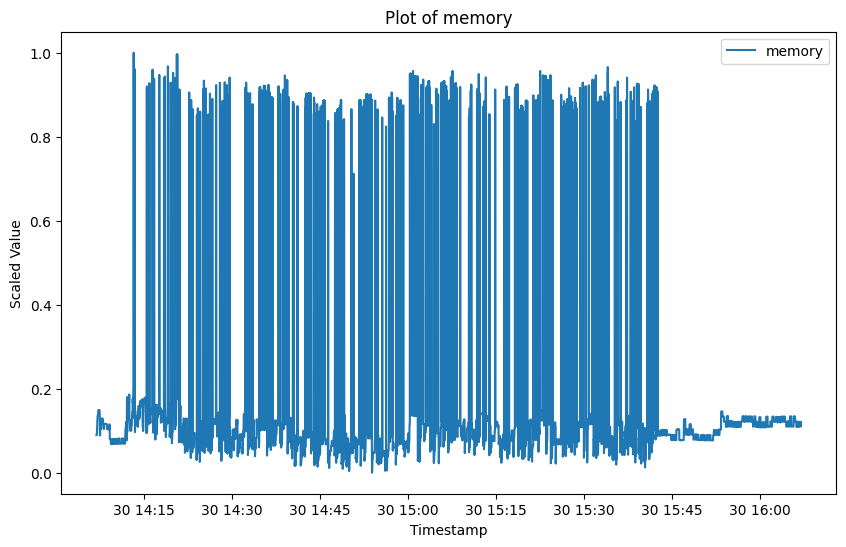

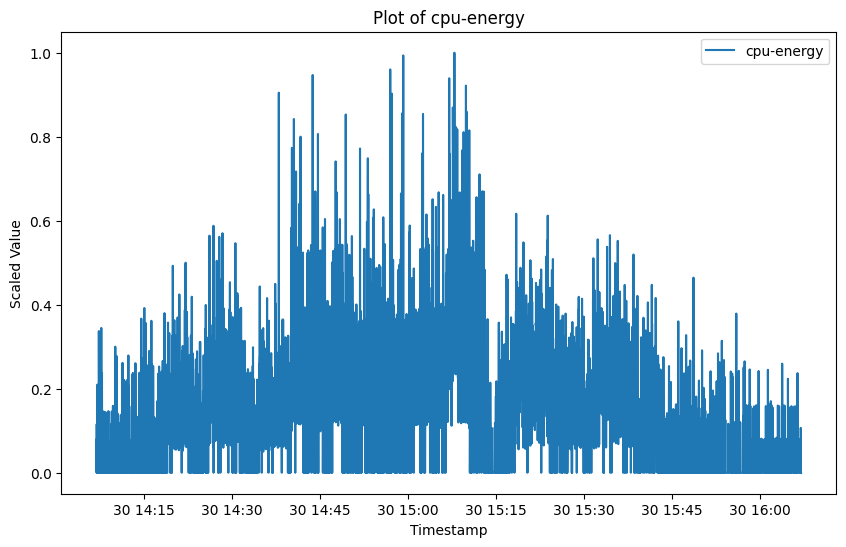

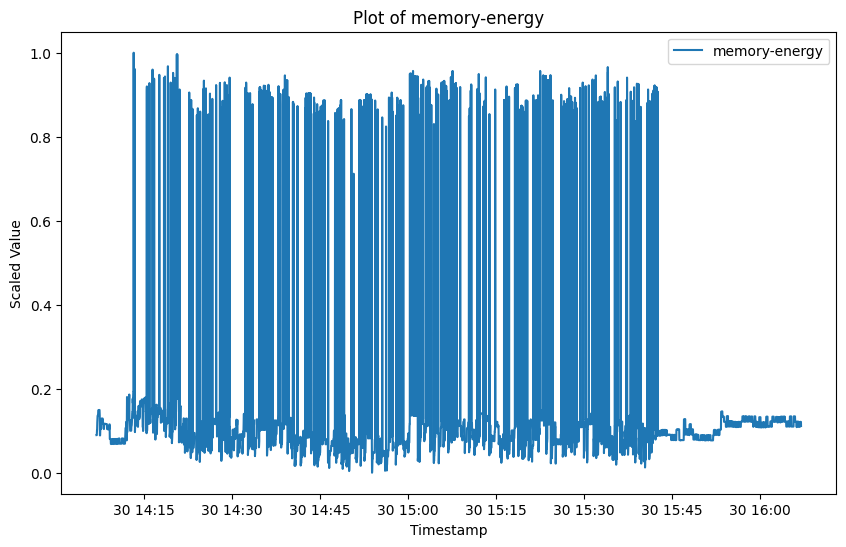

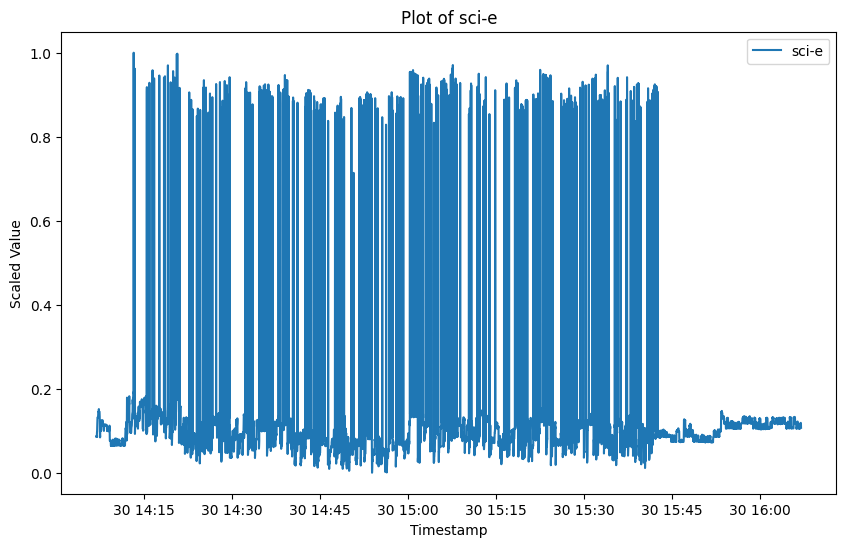

In [4]:
# Plot each feature separately
for column in scaled_df.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(scaled_df.index, scaled_df[column], label=column)
    plt.title(f'Plot of {column}')
    plt.xlabel('Timestamp')
    plt.ylabel('Scaled Value')
    plt.legend()
    plt.show()

In [5]:
scaled_df = scaled_df.drop(columns=['cpu-energy','memory-energy'])

We observe that the memory-energy is similar to memeory and cpu-energy is similar to cpu in terms of values. Hence are not adding any extra value to the dataset. Therefore we drop those dataset.

In [6]:
def create_lag_features(df, lag=1):
    for col in df.columns:
        for i in range(1, lag + 1):
            df[f'{col}_lag_{i}'] = df[col].shift(i)
    df.dropna(inplace=True)
    return df

lagged_df = create_lag_features(scaled_df, lag=3)


In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

# Define the target variable and features
X = lagged_df.drop(columns=['cpu','memory','sci-e'])
y = lagged_df[['cpu','memory','sci-e']]

train_size = int(len(lagged_df)*0.8)
# Split the data
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for LSTM [samples, timesteps, features]
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
y_train = y_train.values
y_test = y_test.values

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(3))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=2, shuffle=False)


Epoch 1/50


C:\Users\sesa572601\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


180/180 - 2s - 11ms/step - loss: 0.0348 - val_loss: 0.0066
Epoch 2/50
180/180 - 0s - 1ms/step - loss: 0.0336 - val_loss: 0.0056
Epoch 3/50
180/180 - 0s - 1ms/step - loss: 0.0334 - val_loss: 0.0048
Epoch 4/50
180/180 - 0s - 1ms/step - loss: 0.0333 - val_loss: 0.0044
Epoch 5/50
180/180 - 0s - 1ms/step - loss: 0.0332 - val_loss: 0.0042
Epoch 6/50
180/180 - 0s - 1ms/step - loss: 0.0332 - val_loss: 0.0040
Epoch 7/50
180/180 - 0s - 1ms/step - loss: 0.0332 - val_loss: 0.0040
Epoch 8/50
180/180 - 0s - 1ms/step - loss: 0.0332 - val_loss: 0.0039
Epoch 9/50
180/180 - 0s - 1ms/step - loss: 0.0332 - val_loss: 0.0038
Epoch 10/50
180/180 - 0s - 1ms/step - loss: 0.0331 - val_loss: 0.0038
Epoch 11/50
180/180 - 0s - 1ms/step - loss: 0.0331 - val_loss: 0.0037
Epoch 12/50
180/180 - 0s - 1ms/step - loss: 0.0331 - val_loss: 0.0037
Epoch 13/50
180/180 - 0s - 1ms/step - loss: 0.0331 - val_loss: 0.0036
Epoch 14/50
180/180 - 0s - 1ms/step - loss: 0.0331 - val_loss: 0.0036
Epoch 15/50
180/180 - 0s - 1ms/step - l

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
RMSE (CPU): 0.0861582427654967
RMSE (MEMORY): 0.02936013062635882
RMSE (SCI-E): 0.030550270181625504


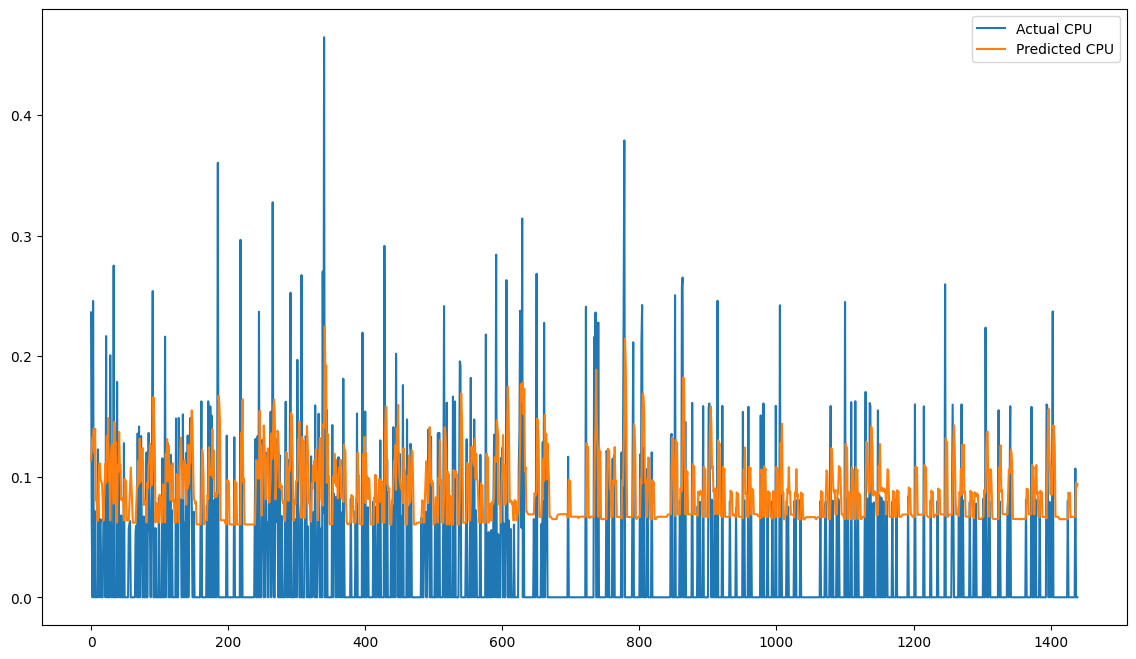

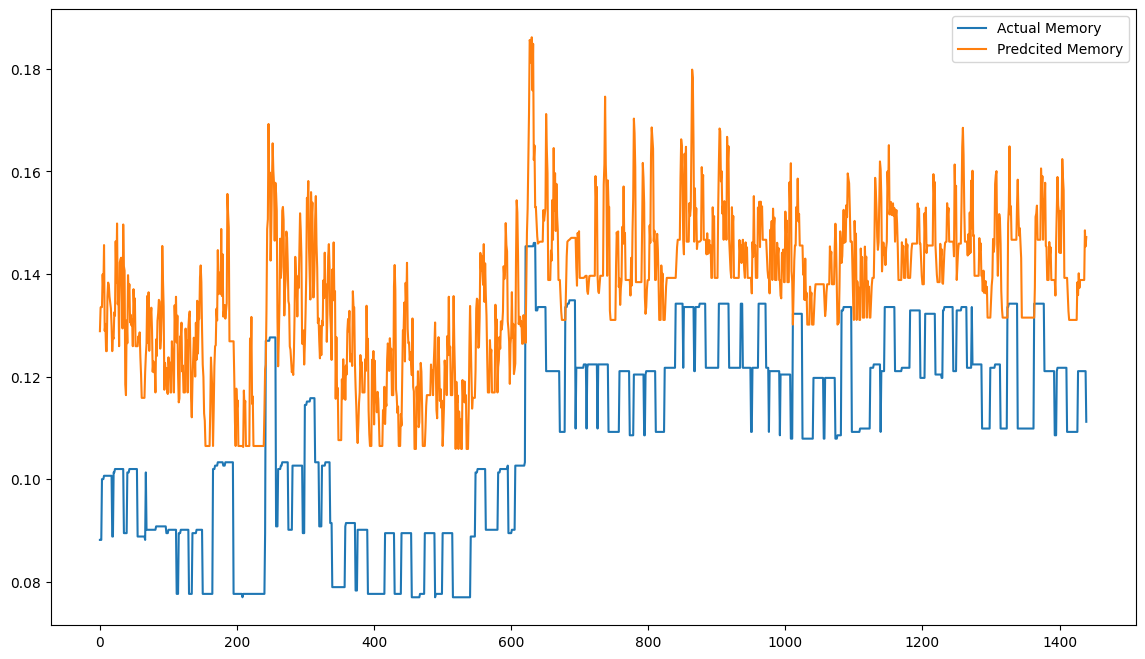

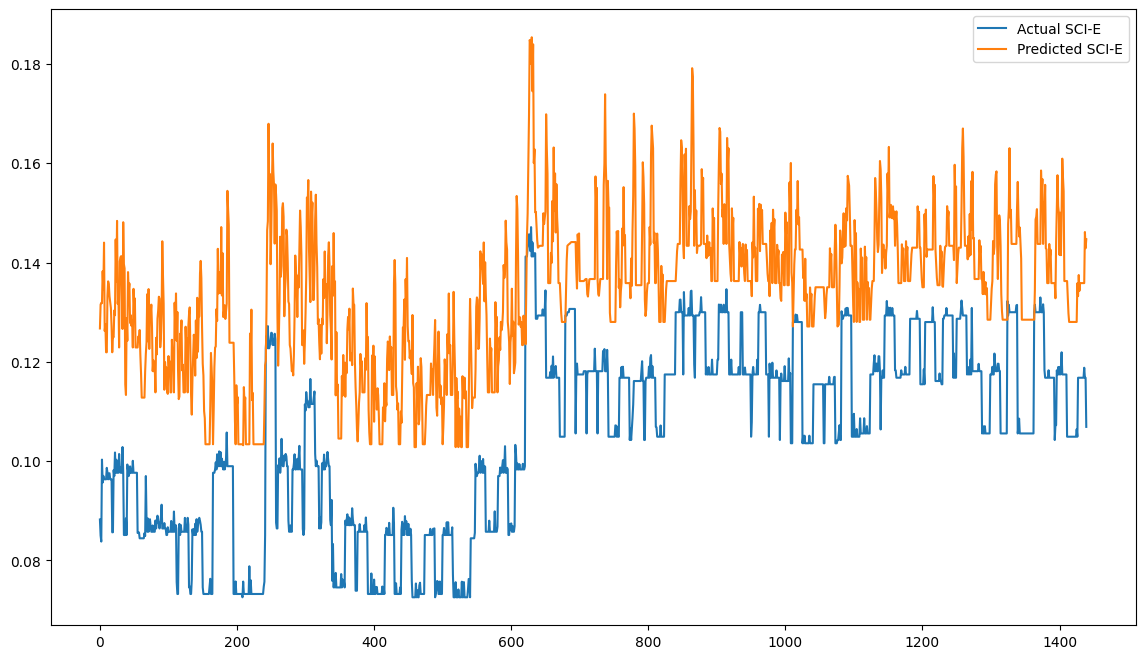

In [9]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Predict
y_pred = model.predict(X_test)

# Evaluate
rmse_cpu = np.sqrt(mean_squared_error(y_test[:, 0],y_pred[:, 0]))
rmse_memory = np.sqrt(mean_squared_error(y_test[:, 1],y_pred[:, 1]))
rmse_sci_e = np.sqrt(mean_squared_error(y_test[:, 2],y_pred[:, 2]))
print(f'RMSE (CPU): {rmse_cpu}')
print(f'RMSE (MEMORY): {rmse_memory}')
print(f'RMSE (SCI-E): {rmse_sci_e}')
            
# Plot predictions
plt.figure(figsize=(14, 8))
plt.plot(y_test[:, 0], label='Actual CPU')
plt.plot(y_pred[:, 0], label='Predicted CPU')
plt.legend()
plt.show()

# Plot predictions
plt.figure(figsize=(14, 8))
plt.plot(y_test[:, 1], label='Actual Memory')
plt.plot(y_pred[:, 1], label='Predcited Memory')
plt.legend()
plt.show()

# Plot predictions
plt.figure(figsize=(14, 8))
plt.plot(y_test[:, 2], label='Actual SCI-E')
plt.plot(y_pred[:, 2], label='Predicted SCI-E')
plt.legend()
plt.show()

In [10]:
model.save('time_series_model.h5')